# **Machine Learning with Apache Spark ML**


![](http://spark.apache.org/images/spark-logo.png)


Spark ML Library is also commonly called MLlib and is used to perform machine learning operations using DataFrame-based APIs.


***


## Setup


In [1]:
!pip3 install pyspark==3.1.2
!pip install findspark
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 25.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880754 sha256=e28989eb17c2e11358b42b4a1fccedb74114bcd49f708e7f14377009a4f04e89
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/ba/f7/a5/95396f2377d918d13405d59f191b5a77af4ad8554ebef73597
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.7
    Uninstalling py4j-0.10.7:
      Successfully uninstalled py4j-0.10.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 2.4.8
    Uninstalling pyspark-2.4.8:
      Successfully uninstalled pyspark-2.4.8


In [2]:
# Pandas is a popular data science package for Python. In this lab, we use Pandas to load a CSV file from disc to a pandas dataframe in memory.
import pandas as pd
import matplotlib.pyplot as plt
# pyspark is the Spark API for Python. In this lab, we use pyspark to initialize the spark context. 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

## Spark session


Create and initialize the Spark session needed to load the dataframes and operate on it


#### Creating the spark session and context


In [4]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

22/11/07 00:57:33 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


#### Initialize Spark session

To work with dataframes I need to verify that the spark session instance has been created.


In [5]:
spark

#### Importing Spark ML libraries

Below 4 SparkML functions will imported.

1.  (Feature library) VectorAssembler(): This function is used to create feature vectors from dataframes/raw data. These feature vectors are required to train a ML model or perform any statistical operations.
2.  (Stat library) Correlation(): This function is from the statistics library within SparkML. This function is used to calculate correlation between feature vectors.
3.  (Feature library) Normalized(): This function is used to normalize features. Normalizing features leads to better ML model convergence and training results.
4.  (Regression Library) LinearRegression(): This function is used to create a Linear Regression model and train it.


In [6]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

## Loading the data and Creating Feature Vectors


In this section, you will first read the CSV file into a pandas dataframe and then read it into a Spark dataframe

Pandas is a library used for data manipulation and analysis. Pandas offers data structures and operations for creating and manipulating Data Series and DataFrame objects. Data can be imported from various data sources, e.g., Numpy arrays, Python dictionaries and CSV files. Pandas allows you to manipulate, organize and display the data.

In this example we use a dataset that contains information about cars.


#### Loading data into a Pandas DataFrame


In [7]:
# Read the file using `read_csv` function in pandas
cars = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars.csv')

In [8]:
# Preview a few records
cars.head()

mpg  cylinders  displacement horsepower  weight  acceleration  model  \
0  18.0          8         307.0      130.0  3504.0          12.0     70   
1  15.0          8         350.0      165.0  3693.0          11.5     70   
2  18.0          8         318.0      150.0  3436.0          11.0     70   
3  16.0          8         304.0      150.0  3433.0          12.0     70   
4  17.0          8         302.0      140.0  3449.0          10.5     70   

   origin                   car_name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

For this example, pre process the data and only use 3 columns. This preprocessed dataset can be found in the `cars2.csv` file.


In [9]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

mpg     hp  weight
0  18.0  130.0  3504.0
1  15.0  165.0  3693.0
2  18.0  150.0  3436.0
3  16.0  150.0  3433.0
4  17.0  140.0  3449.0

#### Loading data into a Spark DataFrame


In [10]:
# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(cars2)

In [11]:
# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



#### Converting data frame columns into feature vectors

In this task we use the `VectorAssembler()` function to convert the dataframe columns into feature vectors.
For our example, we use the horsepower ("hp) and weight of the car as input features and the miles-per-gallon ("mpg") as target labels.


In [13]:
assembler = VectorAssembler(
    inputCols=["hp", "weight"],
    outputCol="features")

output = assembler.transform(sdf).select('features','mpg')

We now create a test-train split of 75%-25%


In [14]:
train, test = output.randomSplit([0.75, 0.25])

## Basic stats and feature engineering


In this exercise, we determine the correlation between feature vectors and normalize the features.


#### Correlation

Spark ML has inbuilt Correlation function as part of the Stat library. Use the correlation function to determine the different types of correlation between the 2 features - "hp" and "weight".


In [15]:
r1 = Correlation.corr(train, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

[Stage 3:>                                                          (0 + 8) / 8]22/11/07 01:17:11 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/07 01:17:11 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Pearson correlation matrix:
DenseMatrix([[1.        , 0.86369574],
             [0.86369574, 1.        ]])


In [16]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.        , 0.88574165],
             [0.88574165, 1.        ]])


There is a 0.86 (or 86%) correlation between the features. That is logical as a car with higher horsepower likely has a bigger engine and thus weighs more. Visualize the feature vectors to see that they are indeed correlated.


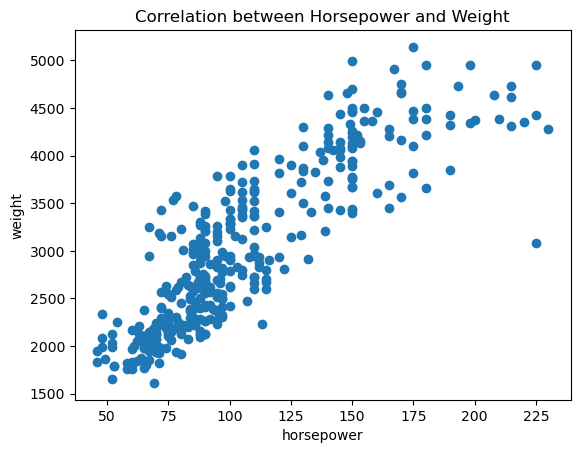

In [17]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

#### Normalization

In order for better model training and convergence, it is a good practice to normalize feature vectors.


In [18]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[72.0,2408.0]|22.0|[0.02903225806451613,0.9709677419354839] |
|[85.0,2587.0]|21.0|[0.03181137724550898,0.968188622754491]  |
|[86.0,2220.0]|23.0|[0.0372940156114484,0.9627059843885516]  |
|[87.0,2672.0]|25.0|[0.031533164189923885,0.9684668358100761]|
+-------------+----+-----------------------------------------+
only showing top 5 rows



#### Standard Scaling

This is a standard practice to scale the features such that all columns in the features have zero mean and unit variance.


In [19]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.1932365526831739,2.153736837262951] |
|[72.0,2408.0]|22.0|[1.8676746041997505,2.8262661057924716]|
|[85.0,2587.0]|21.0|[2.204893629958039,3.0363581460486393] |
|[86.0,2220.0]|23.0|[2.2308335550163685,2.6056107785960494]|
|[87.0,2672.0]|25.0|[2.2567734800746986,3.136122522706596] |
+-------------+----+---------------------------------------+
only showing top 5 rows



In [20]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+--------------+----+---------------------------------------+
|features      |mpg |features_scaled                        |
+--------------+----+---------------------------------------+
|[88.0,2130.0] |27.0|[2.2827134051330282,2.4999779091935066]|
|[88.0,3302.0] |19.0|[2.2827134051330282,3.875552608524394] |
|[90.0,2264.0] |28.0|[2.334593255249688,2.6572535147484033] |
|[90.0,2648.0] |21.0|[2.334593255249688,3.107953757532585]  |
|[100.0,3329.0]|17.0|[2.5939925058329867,3.9072424693451566]|
+--------------+----+---------------------------------------+
only showing top 5 rows



## Building and Training a Linear Regression Model


Train a Linear Regression model `lrModel` on the training dataset. Train the model on the standard scaled version of features.
Also print the final RMSE and R-Squared metrics.


#### Create and Train model

Create the model using the `LinearRegression()` class and train using the `fit()` function.


In [21]:
# Create a LR model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

22/11/07 01:33:29 WARN util.Instrumentation: [d14b104c] regParam is zero, which might cause numerical instability and overfitting.
22/11/07 01:33:30 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/07 01:33:30 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Coefficients: [-1.7136975579706917,-5.005253917390156]
Intercept: 45.56022395065547
RMSE: 4.288882
R-squared: 0.698719


A RMSE (Root mean squared error) of 4.26. This means that the model predicts the `mpg` with an average error of 4.2 units.


#### Predict on new data

Once a model is trained,  can then `transform()` new unseen data (for eg. the test data) to generate predictions.
In the below cell, notice the "prediction" column that contains the predicted "mpg".


In [22]:
lrModel.transform(test_scaled).show(5)

+--------------+----+--------------------+------------------+
|      features| mpg|     features_scaled|        prediction|
+--------------+----+--------------------+------------------+
| [88.0,2130.0]|27.0|[2.28271340513302...| 29.13531933935239|
| [88.0,3302.0]|19.0|[2.28271340513302...| 22.25021868686368|
| [90.0,2264.0]|28.0|[2.33459325524968...| 28.25920862608603|
| [90.0,2648.0]|21.0|[2.33459325524968...|26.003339470321805|
|[100.0,3329.0]|17.0|[2.59399250583298...|21.558164652132174|
+--------------+----+--------------------+------------------+
only showing top 5 rows



### Question 1 - Correlation


Print the correlation matrix for the test dataset split we created above.


In [ ]:
# Code block for learners to answer

Double-click **here** for the solution.

<!-- The answer is below:

r1 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

-->


### Question 2 - Feature Normalization


Normalize the training features by using the L2 norm of the feature vector.


In [ ]:
# Code block for learners to answer

Double-click **here** for the solution.

<!-- The answer is below:

normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)
rint("Normalized using L^1 norm\n"+str(train_norm_l2))
train_norm_l2.show(5, truncate=False)

-->


### Question 3 - Train Model


Repeat the model training shown above for another 100 iterations and report the coefficients.


In [ ]:
# Code block for Question 3

## Authors


[Karthik Muthuraman](https://www.linkedin.com/in/karthik-muthuraman/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMBD0231ENSkillsNetwork26766988-2022-01-01)


### Other Contributors


[Jerome Nilmeier](https://github.com/nilmeier/)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2022-07-14        | 0.4     | Lakshmi Holla | Added code for pyspark  |
| 2021-12-22        | 0.3     | Lakshmi Holla | Made changes in scaling |
| 2021-08-05        | 0.2     | Azim          | Beta launch             |
| 2021-07-01        | 0.1     | Karthik       | Initial Draft           |


Copyright © 2021 IBM Corporation. All rights reserved.
